## LL

In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
save_dir = '/home/hanna/MS-suppl/files/'
sat_dir = '/home/hanna/lagrings/satelite_coordinates/msthesis/'

ex_fil = glob.glob(save_dir + '*ERA5*.json')[0]
with open(ex_fil, 'r') as f:
    data_grid = json.load(f)

In [3]:
satfil = glob.glob(sat_dir + '*nc')[-1]

In [4]:
satfil

'/home/hanna/lagrings/satelite_coordinates/msthesis/cloud_mask.nc'

In [5]:
def read_dlon_dlat(save_dir):
    nc_files = glob.glob(save_dir+'*cell*.json')
    #print(nc_files)
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [6]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)

In [7]:
def clean_file(satfil):
    if satfil.split('.')[-1] == 'grb':
        print("detect grib file")
        cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')
        o = cloudMask['p260537'].values.reshape( (3712, 3712) )
        o[o>=3.0]=np.nan
        o[o==1.0]=0
        o[o==2.0]=1.0
    else:
        print(" Detect nc file - this is already rewritten to binary.")
        cloudMask = xr.open_dataset(satfil)
        #print(cloudMask)
        o = cloudMask['cloudMask'].values.reshape( (3712, 3712) )
    
    #import seaborn as sns
    #sns.heatmap(o)
    #plt.show()
    
    return o

In [8]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [9]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [10]:
data_dict = get_dict_with_all_keys()

In [11]:
data_dict.keys()

dict_keys(['50.25', '50.5', '50.75', '51.0', '51.25', '51.5', '51.75', '52.0', '52.25', '52.5', '52.75', '53.0', '53.25', '53.5', '53.75', '54.0', '54.25', '54.5', '54.75', '55.0', '35.25', '35.5', '35.75', '36.0', '36.25', '36.5', '36.75', '37.0', '37.25', '37.5', '37.75', '38.0', '38.25', '38.5', '38.75', '39.0', '39.25', '39.5', '39.75', '40.0', '40.25', '40.5', '40.75', '41.0', '41.25', '41.5', '41.75', '42.0', '42.25', '42.5', '42.75', '43.0', '43.25', '43.5', '43.75', '44.0', '44.25', '44.5', '44.75', '45.0', '30.0', '30.25', '30.5', '30.75', '31.0', '31.25', '31.5', '31.75', '32.0', '32.25', '32.5', '32.75', '33.0', '33.25', '33.5', '33.75', '34.0', '34.25', '34.5', '34.75', '35.0', '45.25', '45.5', '45.75', '46.0', '46.25', '46.5', '46.75', '47.0', '47.25', '47.5', '47.75', '48.0', '48.25', '48.5', '48.75', '49.0', '49.25', '49.5', '49.75', '50.0'])

In [12]:
data_dict['50.25'].keys()

dict_keys(['-15.0', '-14.75', '-14.5', '-14.25', '-14.0', '-13.75', '-13.5', '-13.25', '-13.0', '-12.75', '-12.5', '-12.25', '-12.0', '-11.75', '-11.5', '-11.25', '-11.0', '-10.75', '-10.5', '-10.25', '-10.0', '-9.75', '-9.5', '-9.25', '-9.0', '-8.75', '-8.5', '-8.25', '-8.0', '-7.75', '-7.5', '-7.25', '-7.0', '-6.75', '-6.5', '-6.25', '-6.0', '-5.75', '-5.5', '-5.25', '-5.0', '-4.75', '-4.5', '-4.25', '-4.0', '-3.75', '-3.5', '-3.25', '-3.0', '-2.75', '-2.5', '-2.25', '-2.0', '-1.75', '-1.5', '-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5', '2.75', '3.0', '3.25', '3.5', '3.75', '4.0', '4.25', '4.5', '4.75', '5.0', '5.25', '5.5', '5.75', '6.0', '6.25', '6.5', '6.75', '7.0', '7.25', '7.5', '7.75', '8.0', '8.25', '8.5', '8.75', '9.0', '9.25', '9.5', '9.75', '10.0', '10.25', '10.5', '10.75', '11.0', '11.25', '11.5', '11.75', '12.0', '12.25', '12.5', '12.75', '13.0', '13.25', '13.5', '13.75', '14.0', '14.25', '14.5

In [13]:
def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        ex = data[lat][lon]
        fraction = 0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0
        #cmk = np.random.randint(low = 0, high=2, size = len(lat_array))

        for key, item in ex.items():
            index = item['index']
            area  = item['area']

            if len(index) == len(area):
                # , "len index, len are = {}, {}".format(len(index), len(area))
                SAT_area += np.nansum(area)
                #print('nans area')
                #print()
                if np.isnan(np.array(area)).sum() > 0:
                    print('Returns nan for lat {}, lon {}'.format(lat, lon))
                fraction += np.nansum(np.array(area)*np.array(cmk[index]) )
            else:
                print('Returns nan for lat {}, lon {}'.format(lat, lon))
                return np.nan, (lat, lon)
            
        return fraction/SAT_area*ERA_area, None
    else:
        print('Please send data as a attribute.')
        return

In [14]:
def compute(satfil):
    o = clean_file(satfil)
    d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

    clouds = o.reshape(-1)

    _all = {}
    fractions = {}

    #ex_fil = glob.glob(save_dir + '*indexes_test*.json')[0]
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        _all.update(data_grid)

    lons = np.arange(-15.0, 25.0, 0.25)
    lats = np.arange(30.0, 50.0, 0.25)    
        
    for lat in lats:
        fractions[str(lat)] = {}
        for lon in lons:
            a, tup = calc_fraction_one_cell(lat = str(lat), 
                                            lon = str(lon), 
                                            cmk = clouds, 
                                            data = _all)

            fractions[str(lat)][str(lon)] = a

    import pandas as pd
    
    return pd.DataFrame.from_dict(fractions)

 Detect nc file - this is already rewritten to binary.


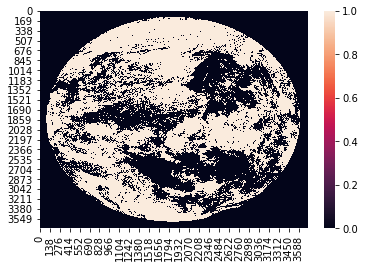

In [15]:
import seaborn as sns
o = clean_file(satfil)
sns.heatmap(o)

In [16]:
df = compute(satfil)

 Detect nc file - this is already rewritten to binary.


In [20]:
sat_dir = '/home/hanna/lagrings/sat_images_2004_2011/'
#data_grid = get_dict_with_all_keys()
#lats = np.arange(-15.0, 25.0, 0.25)
#lons = np.arange(30.0, 50.0, 0.25)
sat_files = glob.glob(sat_dir + "./**/*.grb", recursive = True)

In [21]:
len(sat_files)

7851

In [38]:
import glob
import xarray as xr
import numpy as np

def timestamp(filename):
    """
    Returns the numpy datetime 64 [ns] for the current date.
    This is a bit hardcoded at the moment ....
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    # TODO make sure all filenames have seconds
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

def merge_ts_to_one_dataset(grb_files, lat = None, lon = None):
    """
    grib_files : list of files
        typically one year?
    """
    data_grid = get_dict_with_all_keys()
    
    counter = 0
    for filename in grb_files:# grb file of satellite image...
        #print(filename)
        if counter == 0:
            #print("enters 0")
            #clou = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction = compute(filename).values.T
            ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  cloud_fraction),
                             #'nr_nans':(['latitude', 'longitude'], cnt_nans),
                            #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                 },
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat),
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension.
            ds = ds.assign_coords(time = ds.time)
            ds = ds.expand_dims(dim = 'time')
            print(ds)
            counter += 1

        else:
            #clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction = compute(filename).values.T
            new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  cloud_fraction),
                                 #'nr_nans':(['latitude', 'longitude'], cnt_nans),
                                 #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                },
                                  coords={'longitude': (['longitude'], lon),
                                          'latitude': (['latitude'], lat),
                                           })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension.
            new_ds = new_ds.assign_coords(time = new_ds.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            print(new_ds)
            
            ds = ds.merge(new_ds)
            counter += 1
    return ds


In [39]:
ds = merge_ts_to_one_dataset(sat_files[:2], lat =  np.arange(30.0, 50.0, 0.25) , lon = np.arange(-15.0, 25.0, 0.25) )

detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040723200000.000000000Z-20040723201255-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 160, time: 1)
Coordinates:
  * longitude  (longitude) float64 -15.0 -14.75 -14.5 ... 24.25 24.5 24.75
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.25 49.5 49.75
  * time       (time) datetime64[ns] 2004-07-23T19:00:00
Data variables:
    tcc        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.3111 41.68
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'


<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 160, time: 1)
Coordinates:
  * longitude  (longitude) float64 -15.0 -14.75 -14.5 ... 24.25 24.5 24.75
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.25 49.5 49.75
  * time       (time) datetime64[ns] 2004-07-23T20:00:00
Data variables:
    tcc        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 42.72


In [40]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 160, time: 2)
Coordinates:
  * time       (time) datetime64[ns] 2004-07-23T19:00:00 2004-07-23T20:00:00
  * longitude  (longitude) float64 -15.0 -14.75 -14.5 ... 24.25 24.5 24.75
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.25 49.5 49.75
Data variables:
    tcc        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 42.72

# Write file and generate filename.

In [ ]:

def output_filename(self, var, start, stop, add_text_begin = ""):
    """
    Add test train or valid in front when this is appropriate.

    OBS: Var should be in terms of variables in the era-interim datasets.
    """
    return (save_dir + add_text_begin + var + "_" + start + "_" +
                stop + "_" + self.season_str + ".nc")
